# 长短期记忆网络LSTM&GRU

**目录**

**1 长短期记忆网络LSTM**<br>

&emsp;&emsp; 1.1 RNN的权重冲突与记忆缺陷<br>
&emsp;&emsp; 1.2 LSTM的计算单元与基本架构<br>
&emsp;&emsp; 1.3 LSTM的计算流程与数学本质探讨<br>
&emsp;&emsp; 1.4 在PyTorch中实现LSTM<br>
&emsp;&emsp; 1.5 LSTM是如何解决梯度问题的？<br><br>
**2 循环门控单元GRU**<br><br>
**3 LSTM与GRU在股价预测数据集上的实战**<br>

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/00.png)

长短期记忆网络（Long Short-Term Memory Network，简称LSTM）是一种特殊的循环神经网络，它于1997年被慕尼黑技术大学的两位神经网络研究者提出，是当代深度学习领域中对时序数据和文字数据都具有重要作用的核心架构之一。在NLP的世界中，RNN为神经网络赋予了“记忆”的能力，LSTM则实现了对这种“记忆”方式的改良和优化——在RNN的基础上，LSTM的研究者们从权重冲突问题出发，提出了恒定梯度回路（Constant Error Carousel，CEC）、记忆细胞、门控单元、内部状态漂移等关键概念，从数学原理、架构设计、应用效率等多个方面革新了循环神经网络，大幅提升了循环网络的效果与性能。经过复杂的数学改造和工程优化，LSTM可以轻松处理拥有数千个时间步的长序列、还能有效缓解RNN中严重的梯度动荡问题，给致力于稳定神经网络训练流程的学者们带来无穷启发。在诞生26年之后，LSTM的论文原文依然是梯度研究方向的金典之作，LSTM算法本身也逐渐发展成为深度学习序列数据领域的根基架构。

今天，尽管自然语言处理领域众多大型模型和更先进的Transformer架构已经占据主流，但面临时间序列问题时，LSTM依然是众多深度学习竞赛和企业应用场景中的首选算法；在许多实际应用场景当中，模块化的LSTM也能够与CNN、GAN等架构有机结合，有效地创造在某些场景下超越transformer算法的效率或性能；同时，在LSTM基础上改进而诞生的GRU等算法，也在时间序列应用场景中有一席之地。LSTM的崛起和其持久的影响无疑为整个循环网络系列在序列数据研究领域确立了不可撼动的地位。今天，让我们一起来探索这一卓越结构背后的奥秘。

# 1 长短期记忆网络LSTM

在开始之前，我想向你简单阐述LSTM本堂课程设计的基本理念（也是这堂课程设计过程中最为耗时的地方）。以下是LSTM中核心计算单元的基本结构，从下图即可看出，LSTM并不是一个简单的算法。略带夸张地说，LSTM的网络结构千结百扣、数据流千回百转、数学表达式嵌套极深，因此99%的教材都是从“LSTM分为三大门、7大公式、4条链路、8组权重”开始进行讲述，仿佛我们只能够去“记住”其流程和顺序，而永远不能真正理解这一算法。事实上，大部分的人在学习了三大门、7大公式后，也无法真正地“记住”这一复杂流程。如何在一堂课中让大家深刻理解、并记住LSTM的本质，这是LSTM教学最为困难的地方。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/LSTM%E6%B5%81%E7%A8%8B%E5%9B%BE1.png)

经过艰深的研究、和不断对课程输出方式的思考，我们注意到**LSTM的结构更像是一台精密的机器**，它由一个个简单的数学流程组合而成，真正复杂的不是单一流程，而是这些流程的组合方式。幸运的是，每个组合方式都有其特定的理由和设计逻辑，通过深度挖掘LSTM算法背后的设计原则和算法发源的根基，我们找到了一套理解难度极低、吸收效率极高、且直击本质的教学逻辑。在本次的课程中，我将为你呈现这一精彩的逻辑，让你轻松获取对LSTM的深度理解。

在接下来的课程中，我将会为你一一解答如下的疑惑：

- **LSTM试图解决RNN的什么问题？**
- **这些问题为什么会催生LSTM现有的网络架构？**
- **LSTM现有的网络架构是什么？它会如何运行？**
- **LSTM架构的优势与局限**

## 1.1 权重冲突与LSTM的解决方案

长短期记忆网络LSTM是在传统循环网络RNN的基础上改良优化而来，因此不可避免地，我们需要从循环网络的缺陷开始谈起。今天，当我们在研究RNN所面临的问题时，我们的关注点往往在梯度消失和梯度爆炸这两种现象上——在之前的课程中我们已经学习过，在RNN的梯度计算过程中存在形如$W^{t-1}$的高次项，其中$t$是序列的长度sequence_length（也就是时间步），因此序列数据越长、迭代次数越多，RNN就越容易发生梯度消失和梯度爆炸现象。

$$
\begin{align*}
\\ 
\frac{\partial L_{t}}{\partial W_{hh}}
&= \frac{\partial L_{t}}{\partial \hat{y}_{t}} * W_{hy} * (W_{hh})^{t-1}* h_0 \\ \\
(在时&间步t时，损失L对W_{hh}的偏导数) \\ \\
\end{align*}
$$

因此，几乎99%的网络教材与公开文件都传言道“LSTM是为了解决RNN的梯度消失和梯度爆炸问题而存在的算法”。然而，当我们想要深入研究LSTM和同时代的其他深度架构究竟是如何解决梯度问题时，却会发现一些十分有趣的事实——一方面，从LSTM的网络结构本身深入挖掘时，很难从其架构本身看出它尝试解决梯度问题的痕迹；另一方面，在LSTM诞生于1997年，那是一个算力和数据都十分匮乏、神经网络层数普遍很浅的年代，在那个时候，研究中所需的迭代次数很少，序列数据的序列长度也普遍较短（梯度计算过程中的$t$往往不是很大），因此RNN的梯度消失和梯度爆炸问题并没有那么显著。当我们数次回溯LSTM原始论文并深入研究后发现，1990年代的大量研究、包括LSTM并不是围绕梯度消失和梯度爆炸问题展开；相对的，LSTM旨在解决RNN在短序列上运行时也会产生的关键问题：**权重冲突（Weight Conflict）**。

在今天，我们可以证明LSTM一定程度上解决了梯度相关的问题，但其设计理念与根本的宗旨是为了克服RNN的权重冲突问题。让我们从这里开始深入。

- **权重冲突的起源：权值共享**

权重冲突是RNN的权值共享机制引发的问题。让我们先简单回顾一下RNN的权值共享机制——首先，在处理序列数据时，RNN是从上向下、从前往后依次按顺序处理样本的，因此对于时间序列数据而言，RNN是一个时间步、一个时间步地按照时间顺序、从过去向未来对数据进行处理的。如下图所示，当RNN的输入数据为三维时间序列时，RNN会对表单上的数据进行并行处理，一次性处理掉所有表单的第一行、第二行……直到全部的表单都被处理完毕。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/Live/NLP%26LLMs/16.png)

在RNN中，只有当全部的表单都被处理完毕后，才会进行一次反向传播，因此在RNN的训练过程中**所有的样本都是共享权重的**，这是RNN解决其效率问题的关键手段，但也造成了相当严重的问题——很显然，当RNN被用于文字序列，全样本共享权重意味RNN在使用相同的权重处理文字序列中有着不同语义、不同情感、不同重要性的词；当RNN被用于时间序列，全样本共享权重则意味着RNN在使用相同的权重处理不同时间点上、包含不同规律、遵循不同逻辑的时间样本。

在现实之中，**不同语义的词语、或者不同时间点上的样本可能对损失函数有着不同的影响，因此可能会赋予权重不同的迭代方向（不同的梯度向量），这些迭代方向之间会互相冲突，并最终导致训练失败**，这就是权重冲突的本质。

- **权重具体是如何冲突？**

在神经网络的实际训练过程中，权重的迭代过程是黑箱且及其复杂的，但我们可以找出一些简单的例子来阐述一些显著的冲突过程。以下是RNN的数学流程的简单图示和数学流程：

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/Live/NLP%26LLMs/15.png)

在任意RNN中，每个时间步上的信息都由当前时间步的样本$X_t$和上个时间步的中间变量$h_t$共同构成，每个$h_t$都要流过【隐藏层-输出层】、【隐藏层-隐藏层】两条路径。在这一数学流程中，涉及到$W_{xh}$、$W_{hh}$和$W_{hy}$三大权重矩阵。我们来看下面的例子具体如何导致这些权重上的冲突——

**<center>我会先去<font color=green>图书馆</font>，再去<font color=green>咖啡店</font>，因为我想先去<font color=red>借书</font>。<center>**

> $W_{xh}$

这是一个生成式任务的例子，其中“借书”是我们要预测的标签。在当前语句中，地点“图书馆”很明显是一个对标签非常关键的词语，毕竟从语义上来说“去图书馆”这个行为会很直接地指向“借书”这一标签，因此循环神经网络应该尽量**长期地记忆并存储这个新信息**。随着时间步的增多，输入RNN的信息都会逐渐被削弱（数值上来说越来越小），因此当一个关键的$X$在被输入网络时，循环网络就需要尽量大的$W_{xh}$来确保信息的输入和传递（参考上面的图），故而“图书馆”一词会逼迫$W_{xh}$向增大的方向迭代（会给予一个能增大$W_{xh}$的梯度）。
    
相对的，地点“咖啡店”对当前预测场景来说就是一个干扰，如果循环神经网络太多地考虑地点“咖啡店”所携带的信息，可能会离预测出“借书”这一正确的标签越来越远。当一个明显有干扰作用的$X$被输入网络的时候，循环网络应该尽量保证这个$X$不会影响之前已经记住的信息，此时循环网络就需要尽量小的$W_{xh}$来**削弱新信息影响、保护原本已经被记住的信息**，故而“咖啡店”一词会逼迫$W_{xh}$向减小的方向迭代（会给予一个能减小$W_{xh}$的梯度）。
    
不幸的是，RNN用来处理“图书馆”和“咖啡店”的权重$W_{xh}$是同一个$W_{xh}$，因此迭代过程中$W_{xh}$就会被迫向冲突的方向进行迭代，也就是会发生“权重冲突”（可能表现为迭代混乱，也可能表现为迭代停滞）。

> $W_{hh}$

这种现象不止会发生在输入端，也会发生在任意隐藏层神经元之间、也会发生在隐藏层与输出层的神经元之间。例如，当携带“图书馆”信息的中间变量$h_t$被传递给下一个时间步时，为了增加这一信息被传递下去的影响力，RNN就会需要巨大的权重$W_{hh}$来加强信息的传递。同时，当携带干扰信息“咖啡店”的中间变量$h_t$被传递给下一个时间步时，RNN可能就会选择降低权重$W_{hh}$来减少这一信息对未来预测的干扰。

再次，不幸的是，这两个$W_{hh}$是同一个$W_{hh}$。因此$W_{hh}$一方面要保证自己输出的重要信息能够传递下去（整合新信息、保持新信息的长期记忆，也就是增大权重），另一方面又要保证自己输出的噪音信息不会干扰到下一个神经元上的信息（减小权重），从而导致权重冲突。

更糟糕的是，在RNN当中，长期信息和短期信息都被包含在同一个变量$h_t$中，因此长期信息和短期信息只能一起被增强或减弱，当$W_{hh}$试图增大权重、保留有效的长期记忆时，也会一并增大短期信息的影响；当$W_{hh}$试图增大权重、保留有效的短期记忆时，也会一并增大长期信息的印象，因此对$W_{hh}$而言，权重迭代方向几乎每时每刻都在发生冲突。<font color=red>**很显然，一个权重无法在整合当前时间步的新信息的同时、也对长期积累的信息进行有效的保护，更无法针对性地处理合并在同一个变量中的长短期信息**</font>，这是权重冲突发生的关键原因之一。

当整合新信息的任务与保护长期积累的有效信息的任务发生矛盾时，$W_{xh}$和$W_{hh}$权重就无法有效迭代，因此中间变量$h_t$的迭代过程就会受到极大的影响。在之前的课程中我们证明过，由于有权重的高次项乘在$X_1$、$X_2$、$X_3$等古老的长期信息之前，因此这些信息在最后的中间状态$h_T$中的比例可以忽略不计（相当于RNN会忘记长期信息）。

$$
\begin{align*}
L_{t} &= L(\mathbf{\hat{y}}_{t}, \mathbf{y}_{t}) \\ \\
&=L(\color{red}{\mathbf{W}_{hy}} (\mathbf{W}_{xh} \mathbf{X}_{t} + \color{red}{\mathbf{W}_{hh}} (\mathbf{W}_{xh} \mathbf{X}_{t-1} + \dots + \color{red}{\mathbf{W}_{hh} (\mathbf{W}_{xh}} \mathbf{X}_{1} + \mathbf{W}_{hh} \mathbf{h}_{0}))...), \mathbf{y}_{t})
\end{align*}
$$

如上述公式所示，最初输入的$X_1$来说前面的连乘项为$\mathbf{W}_{hy}(\mathbf{W}_{hh})^{t-2}\mathbf{W}_{xh}$，对于$X_2$来说前面的连乘项为$\mathbf{W}_{hy}(\mathbf{W}_{hh})^{t-3}\mathbf{W}_{xh}$，在这种情况下，如果权重$W_{xh}$、$W_{hh}$和$W_{hy}$迭代得当、比例恰当，RNN还有一定的机会保持相对长的记忆。然而在RNN实际运行过程中，权重一面要保护长期信息、一面要整合短期的新信息，极其容易迭代失效，因此长期信息和短期信息的比例就会严重失衡，**进一步加剧了RNN会遗忘长期记忆的问题**。

> $W_{hy}$

在实际迭代过程中，权重冲突可能变得更加复杂。例如，$h_t$不仅同时包含了长期信息化和短期信息，它作为唯一向下一个时间步传递信息的中间变量，很可能同时包含了关键信息“图书馆”和干扰信息“咖啡店”。当同时携带“图书馆”和“咖啡店”这两种信息的$h_t$被传递到需要预测“借书”标签的时间步时，$W_{hy}$一面需要努力增大$h_t$的影响，以增大“图书馆”这一信息的影响，但同时也要削弱$h_t$的影响，以削弱“咖啡店”这一信息的影响，此时对当前时间步上预测的需求本身就会导致权重冲突，最终权重可能迭代失效。

<font color=red>**很显然，在进行当前时间步的预测时，一个权重无法在排除干扰信息的同时又提取出关键信息，即无法针对性地处理合并在同一个变量中的重要信息和干扰信息**</font>。在实际迭代中，$h_t$永远是同时包含有效信息和无效信息的，而RNN并不具备筛选信息的能力，这也是权重会发生冲突的关键原因之一。

在LSTM论文中，**神经元在接收信息时发生的冲突被称之为输入权重冲突（Input Weight Conflict），神经元在输出信息时发生的冲突被称之为输出权重冲突（Output Weight Conflict）**。这两种冲突方式对权重来回拉扯，严重影响RNN迭代的方向和效率，当需要处理的序列变长的时候，冲突的情况会变得越来越明显——毕竟，随着时间步越来越长，重要信息需要被保存的时间也会变得越来越长，而干扰的信息也会变得越来越多，因此冲突会越来越激烈。时至今日，权重冲突依然是RNN不擅长学习长序列、无法稳定迭代的关键原因之一。

- **LSTM克服权重冲突的基本思路**

根据上面的例子和说明，你可能已经发现了两个关键点：

> - **单一权重无法满足复杂数据的需求**，要求一个权重同时执行多个矛盾的任务必然会造成冲突，<br><br>
> - **信息的混合是巨大的问题**，当有效信息/无效信息/长期信息/短期信息混杂在一起，权重冲突会更加激烈、RNN算法的长期遗忘、迭代不稳定等问题都会被加剧

如果解决这两个问题，就可以改进RNN所面临的权重冲突问题，因此研究者们在设计LSTM的时候提出了以下的改进方案——

>- 首先，**要分割长期信息与短期信息**；LSTM使用两个不同的变量来来分别承载长期信息和短期信息，并使两个变量分别迭代<br><br>
>- 其次，**创造多组全新的权重、分别服务于网络中不同数据、不同任务的需求**，包括——
>> 1. 专用于<font color=red>**判断保留多少长期信息**</font>的1组权重<br><br>
>> 2. 专用于<font color=red>**解读新信息含义、以及判断接纳多少新信息**</font>的2组权重，以上3组权重共同解决“新信息存储和长期信息保护”之间的输入权重冲突问题<br><br>
>> 3. 专用于<font color=red>**判断对当前时间步的预测来说最有效的信息**</font>的1组权重，这一权重主要解决干扰信息和关键信息混杂在一起导致的输出权重冲突

这样的解决方案，为LSTM赋予了选择性记忆和选择性传递信息的能力，为LSTM增加了循环神经网络所不具备的巨大领活动。这里的“选择性”包含多层含义，包括：

> **1. 自行选择吸纳多少新信息的能力**

> **2. 自行选择遗忘多少历史信息、保留多少历史信息的能力**

> **3. 自行判断、对当前时间步的预测来说最重要的信息是哪些，并输出该信息的能力**

这三种能力构成了LSTM的基本结构和运算流程。接下来就让我们来看看LSTM是如何实现以上三种能力的。

## 1.2 LSTM的计算单元与基本架构

LSTM算法的结构本身十分繁复，无论是从网络架构还是数学原理角度出发，我们都很难使用简单的语言将LSTM完整呈现。然而幸运的是，在了解研究者们要为RNN增加的三大类能力后，我们会发现LSTM的思路是非常清晰的。让我们一起来看看LSTM的基本结构——

- **记忆细胞**

首先，**LSTM依然是一个循环神经网络，因此LSTM的网络架构与RNN高度相似，同时LSTM也是需要遍历所有时间步，不断完成循环和嵌套的**。但不同的是，RNN由输入层（输入$X_t$）、隐藏层和输出层（输出$Y_t$）构成，而LSTM由输入层（输入$X_t$）、**记忆细胞（Memory Cell）**和输出层（输出$Y_t$）构成，其中输入、输出层与RNN的输入、输出层完全一致，而记忆细胞是LSTM独有的结构。

![](http://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/02_.png)

当我们绘制三维的架构图，LSTM的图像与RNN的图像完全一致，只不过在RNN当中，图上蓝色的神经元是一个个隐藏层上的线性神经元，而在LSTM中，蓝色的神经元就是一个个的记忆细胞。

![](http://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/Live/NLP%26LLMs/14.png)

**记忆细胞是LSTM的基本计算单元，在记忆细胞中，我们分割长期信息与短期信息，同时赋予循环网络对信息做选择的能力**。在之前我们提到，LSTM能够自行决定哪些长期信息会被传递下去，哪些短期信息对当前的预测最为有效，因此在记忆细胞当中，LSTM设置了两个关键变量：

> - **主要负责长期记忆的细胞状态$C$，**以及
> - **主要负责记忆短期信息、尤其是当前时间步信息的隐藏状态$h$。**

这两个变量都随着时间步进行迭代。如下图所示，在迭代开始时，LSTM会同时初始化$h_0$和$C_0$；在任意时间步t上，记忆细胞会同时接受到来自上一个时间步的长期记忆$C_{t-1}$、短期信息$h_{t-1}$以及当前时间步上输入的新信息$X_t$三个变量，结合三者进行运算后，记忆细胞会输出当前时间步上的长期记忆$C_{t}$和短期信息$h_{t}$，并将它们传递到下一个时间步上。同时，在每个时间步上，$h_t$还会被传向当前时间步的输出层，用于计算当前时间步的预测值$\hat{y}_t$。

![](http://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/02_.png)

那在记忆细胞的内部，究竟是如何进行具体的$C_t$和$h_t$计算的呢？让我们来看看记忆细胞内部的流程图：

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/LSTM%E6%B5%81%E7%A8%8B%E5%9B%BE1.png)

这是一个复杂的流程，但在横向上，它可以被分割为C的传递和h的传递两条路径；在纵向上，它可以被分为如图所示的三个不同的路径：

**1. 帮助LSTM选择吸纳多少新信息的输入门**

**2. 帮助LSTM选择遗忘多少历史信息的遗忘门**，以及

**3. 帮助LSTM选择出对当前时间步的预测来说最重要的信息、并将该信息输出给当前时间步的输出门**

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/LSTM%E6%B5%81%E7%A8%8B%E5%9B%BE2.png)

让我们分别来看一下三个门是如何工作的。

- **遗忘门**

**遗忘门是决定要留下多少长期信息C的关键计算单元，其数学本质是令上一个时间步传入的$C_{t-1}$乘以一个[0,1]之间的保留比例$f_t$，以此筛选掉部分旧信息。**在这个计算过程中，假设保留比例为0.7，那遗忘门就会令$C_{t-1}$乘以0.7，以保留70%的历史信息，遗忘30%的历史信息。当被遗忘后，这30%的信息空间就可以留给全新的信息来使用。

![](http://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/09.png)

很显然，遗忘门是致力于解决“输入权重冲突”的关键结构之一，它包含了负责判断保留多少长期信息的权重$W_{xf}$和$W_{hf}$，这两个权重也可以被合并写作$W_f$，表示遗忘门上的那组权重。在遗忘门中，核心的数学过程就是保留比例$f_t$的计算。

$$f_t = \sigma(W_{xf} \cdot x_t + W_{hf} \cdot h_{t-1} + b_f)$$

如公式所示，权重$W_{xf}$会与当前时间步的信息$X_t$相乘，权重$W_{hf}$会与上一个时间步的短时信息$h_{t-1}$相乘，两者相加后加上偏置$b_f$，**这代表保留比例的计算同时参考了最近的“上下文信息”**。在此基础上套上sigmoid函数$\sigma$，就可以将上下文携带的信息归一化到[0,1]之间，这样计算出的比例就是保留比例$f_t$。在上面的图像中，该公式是以矩阵的形式呈现。从数学结果上来说，先对$X_t$和$h_{t-1}$进行堆叠，在乘以权重矩阵$W_f$所得到的效果与公式代数矩阵所得到的效果完全一致。在实际计算时，我们可以选择是否要添加偏置作为模型参数的一部分。

在LSTM的设计逻辑之中，考虑$X_t$和$h_{t-1}$实际是在考虑离当前时间步最近的**上下文信息**，而权重$W_f$会受到**损失函数和算法整体表现的影响，不断调节遗忘门中计算出的比例f的大小**，因此遗忘门能够结合上下文信息、损失函数传来的梯度信息、以及历史信息共同计算出全新的、被留下的长期记忆$C_t$。这个流程在实践中被证明是十分有效的。

- **输入门**

**输入门是决定要吸纳多少新信息来融入长期记忆C的计算单元，其数学本质是在当前时间步传入的所有信息$\tilde{C}_t$上乘以一个[0,1]之间的纳入比例$i_t$，以筛选掉部分新信息，将剩余的新信息融入长期记忆C**。与遗忘门一致，输入门是致力于解决“输入权重冲突”的关键结构之一，它包含了负责解读新信息含义的权重组$W_{xc}$和$W_{hc}$、以及判断接纳多少新信息的权重组$W_{xi}$和$W_{hi}$。其中，$W_{xc}$和$W_{hc}$可以被合并写作$W_c$，$W_{xi}$和$W_{hi}$可以被合并写作$W_i$。

![](http://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/07.png)

> 输入总信息 $\tilde{C}_t$

在输入门中，我们首先要计算出当前时间步总共吸收了多少全新的信息$\tilde{C}_t$，这个计算全新信息的方式就与RNN中计算$h_t$的方式高度相似，$\tilde{C}_t$也是由当前时间步上的$x_t$与上个时间步传过来的$h_{t-1}$构成的：

$$\tilde{C}_t = \tanh(W_{xc} \cdot x_t + W_{hc} \cdot h_{t-1} + b_C)$$

在图像上，我们使用的是矩阵的表达方式，其数学流程与上述公式完全一致。需要注意的是，输入门中的$h_{t-1}$并不携带长期信息，而只携带短期信息，因此**这里的$\tilde{C}_t$本质是在整合“最近的上下文信息”**。

> 纳入比例 $i_t$

接着，我们要计算用于纳入新信息的纳入比例$i_t$，具体公式如下：

$$i_t = \sigma(W_{xi} \cdot x_t + W_{hi} \cdot h_{t-1} + b_i)$$

同样是参考最近的上下文信息，我们依然使用$x_t$、$h_{t-1}$和sigmoid函数来生成纳入比例。在输入门中，最终被纳入长期信息的新信息是$i_t \cdot \tilde{C}_t$。

可以看到，相比起RNN的数据输入过程，LSTM的输入过程灵活了非常多——在输入门当中，**我们不仅对输入数据加上了纳入比例$i_t$，还分别使用了两组受损失函数影响的权重$W_i$和$W_C$来控制新信息聚合和比例计算的流程**。在这一比例和两大参数的作用下，输入数据可以被高度灵活地调节，以便满足最佳的损失函数需求。

- **更新细胞状态**

当遗忘门决定了哪些信息要被遗忘，输入门决定了哪些信息要被加入到长期记忆后，LSTM就可以更新用于控制长期记忆的细胞状态C了。如下图所示，上一个时间步的长期记忆将乘以遗忘门给出的保留比例$f_t$，再加上新信息$\tilde{C}_t$乘以纳入比例$i_t$，同时考虑放弃过去的信息、容纳新信息，以此来构成传递给下一个时间步的长期信息$C_t$，这就是长期记忆$C$的迭代过程。

![](http://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/03.jpg)

在遗忘门和输出门的流程中，我们可以简单窥见LSTM是如何解决输入权重冲突问题的。

$$遗忘门中的保留比例：f_t = \sigma(W_{xf} \cdot x_t + W_{hf} \cdot h_{t-1}+ b_f)$$

$$输入门中的纳入比例：i_t = \sigma(W_{xi} \cdot x_t + W_{hi} \cdot h_{t-1}+ b_i)$$

$$输入门中的输入总信息：\tilde{C}_t = \tanh(W_{xc} \cdot x_t + W_{hc} \cdot h_{t-1}+ b_C)$$

$$更新长期记忆：C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t$$

我们依然使用之前的例子——

**<center>我会先去<font color=green>图书馆</font>，再去<font color=green>咖啡店</font>，因为我想先去<font color=red>借书</font>。<center>**
    

其中“借书”是我们要预测的标签。在当前语句中，地点“图书馆”很明显是一个对标签非常关键的词语，从语义上来说“去图书馆”这个行为会很直接地指向“借书”这一标签，因此LSTM应该尽量长期地记忆并存储这个新信息，并在历史信息中为这个新信息腾挪位置。

但与RNN不同的是，LSTM可以在很多环节上做出调整，以尽量多地存储这个新信息。比如，LSTM可以放大$W_{xi}$或者$W_{xc}$来保障新信息的存储，也可以选择减小$W_{xf}$、$W_{hf}$、$W_{hi}$等权重来减小历史信息和其他信息所占的空间。**但具体如何选择，会由损失函数、当前时间点的信息$x_t$以及上一个时间步上的短时记忆$h_{t-1}$来共同决定，LSTM不一定会同时调节所有的权重**。在迭代过程中，LSTM会自行选择调节权重的方式。
    
相对的，地点“咖啡店”对当前预测场景来说就是一个干扰，当一个明显有干扰作用的$X$被输入LSTM的时候，LSTM应该尽量保证这个$X$不会影响之前已经记住的信息。如果是RNN，就只能靠削弱输入信息时使用的权重来解决问题，从而引发权重冲突，但是LSTM有很多种选择，它不一定要减小$W_{xi}$或者$W_{xc}$来削弱新信息的影响；相对的，它可以通过增大$W_{xf}$、$W_{hf}$、$W_{hi}$等权重来增大历史信息和其他信息所占的空间，侧面地削弱新信息的影响，从而避开权重冲突。

很显然，LSTM创造多组全新的权重、并令他们分别服务于网络中不同数据、不同任务的需求后，算法在面对可能冲突的信息时就有了更多选择、有了更多灵活的可能。这些灵活的可能令算法可以更有效地迭代下去，而不会轻易陷入权重冲突的困境。

- **输出门**

最后我们来到了输出门。**输出门是从全新的长期信息$C_t$中筛选出最适合当前时间步的短期信息$h_t$的计算单元，其数学本质是令已经计算好的长期信息$C_t$乘以一个[0,1]之间的输出比例，以此筛选出对当前时间步最有效的信息$h_t$。**具体流程如下所示。

![](http://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/08.png)

输出门是致力于解决“输出权重冲突”的关键结构，它包含了负责判断“多少信息对当前时间步有用”的权重$W_{xo}$和$W_{ho}$，这两个权重也可以被合并写作$W_o$，代表输出门上的那组权重。在输出门中，我们要经历两个关键数学流程——

1. 借助上下文信息和权重$W_o$求解出输出比例$o_t$

$$o_t = \sigma(W_{xo} \cdot x_t + W_{ho} \cdot h_{t-1} + b_o)$$

2. 对长期信息$C_t$进行tanh标准化处理后，乘以$o_t$求解出$h_t$

$$h_t = o_t \cdot \tanh(C_t)$$

在了解遗忘门和输入门的流程之后，输出门的流程很容易理解，我们依然是使用上下文信息和sigmoid函数来求解出比例，并依赖该比例求解出对当前时间步最为有效的信息$h_t$。在这个计算过程中，有两个点值得注意——

> - **输出门是唯一有两个输出路径的门**。<br><br>
在输出门中计算出的$h_t$要承担两大职责，其一是进入整个LSTM的输出层，负责生成预测标签$\hat{y}$，以辅助损失函数的计算；其二，作为当前时间步上最有效的短期信息，$h_t$需要进入下一个是啊进步的细胞状态，作为“上下文”辅助下一个时间步的历史信息筛选、新信息筛选和输出。在这个过程中，还会存在记忆细胞与输出门之间的链接上的权重$W_{hy}$，因此在不需要对每个时间点进行预测的任务中，只需要让$W_{hy}$为0即可。
<br><br>
> - **为什么要对长期信息$C_t$做标准化处理？** <br><br>
最初Tanh标准化只是继承自RNN中Tanh激活函数的一种习惯，在RNN中我们使用Tanh激活函数作用于中间变量$h_t$，以帮助我们控制长期传递的信息的数字范围、避免信息在传递过程中变得越来越大，因此在LSTM中研究者们也保留了这一选项。除此之外，在使用众多sigmoid函数求解比例的LSTM流程中，急需更为丰富的非线性手段来提升模型的综合学习能力，Tanh函数可以为输出门赋予一定的非线性性质，承担激活函数的作用。这个过程在实践中被证明有助于保持训练稳定、并能够强化算法学习能力，因此在LSTM最终的设计中被保留了下来。

我们可以很容易看出输出门是如何解决输出权重冲突问题的——很显然，**输出门赋予了LSTM判断干扰信息和重要信息的能力**。在这个过程中，如果需要增强重要信息、削弱干扰信息，输出门可以通过调节$W_{ho}$和$W_{xo}$来实现。同时，如果历史信息中干扰信息太多，那从损失函数传回的信息也会帮助输出门来调节遗忘门、输入门中的权重，以此来找到最为适合当前时间步的输出。

这就是记忆细胞的全部数学过程。在这个过程中我们能够看到LSTM是如何为RNN赋予了各种灵活的能力，从而实现了多个层次上的“信息筛选”、并避免权重冲突的。通过分割长短期信息、以及设置多组权重的方式，LSTM有效改善了RNN在权重冲突方面的困境。遗忘门、输入门和输出门的设计被称为是“门控单元结构”，今天门控单元被认为是使用上下文计算比例、并使用该比例筛选信息的关键结构，在未来的许多算法中我们也可以看到类似的结构，LSTM令这一结构发扬光大。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/01.png)

![](http://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/Live/NLP%26LLMs/14.png)

## 1.3 LSTM的计算流程与数学本质探讨

现在你已经了解了LSTM的基本结构了，但这个架构中有许多值得探讨的关键内容，包括但不限于LSTM的数学流程是如何在架构上具体实现的，以及各个数学流程究竟是如何各司其职的。了解并探讨这些问题可以帮助我们更好地理解LSTM在实践中的操作，同时也可以帮助我们更好地接入LSTM与其他架构结合所构成的融合架构。本节让我们来一一探讨这些值得挖掘的技术细节。

- **遗忘、输入与输出门为什么叫做“门”？他们如何执行“门”的作用？**

深度学习中的各个数学流程是如何各司其职的？例如，在LSTM中，我们设计了长期记忆$C$和短期信息$h$，同时还设计了遗忘、输入、输出三大门控单元。但这些机制是如何起到和它们的名字类似的作用的呢？

这样的问题在深度学习中随处可见，这些点也往往是深入算法原理的关键突破口。例如，残差链接中的残差在哪里？遗忘门真的能控制遗忘、输出门真的能控制输出吗？Transformer中的Q矩阵负责查询，K矩阵负责索引，V矩阵负责内容，为什么这些矩阵可以执行这些职责呢？这些理所当然的“事实”是如何实现的？**当然不可能是靠“起名”来实现的**。

回顾LSTM的数学流程——

$$遗忘门中的保留比例：f_t = \sigma(W_{xf} \cdot x_t + W_{hf} \cdot h_{t-1}+ b_f)$$

$$输入门中的纳入比例：i_t = \sigma(W_{xi} \cdot x_t + W_{hi} \cdot h_{t-1}+ b_i)$$

$$输入门中的输入总信息：\tilde{C}_t = \tanh(W_{xc} \cdot x_t + W_{hc} \cdot h_{t-1}+ b_C)$$

$$更新长期记忆：C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t$$

$$输出门中的输出比例：o_t = \sigma(W_{xo} \cdot x_t + W_{ho} \cdot h_{t-1} + b_o)$$

$$短期记忆生成：h_t = o_t \cdot \tanh(C_t)$$

不难发现，虽然我们在三个门中分别生成了保留比例$f_t$，纳入比例$i_t$以及输出比例$o_t$，但这三个比例的计算公式本质上是完全一致的。对LSTM算法来说，它当然不会因为自己的各个数学流程被取了名字就执行这个名字对应的任务，在遗忘门中LSTM并无法意识到自己给长期记忆乘以一个比例的行为是在进行“遗忘”，它只是在筛选更有效的历史信息而已，因此“遗忘门”这个名字被更换成“记忆门”、“长期记忆筛选门”也没有问题，其本质就是一个**筛选信息**的计算过程，损失函数指导的也是信息的筛选流程。

故而在LSTM中，遗忘门负责遗忘、输入门负责输入，这都只是一种“写意”的说法。**在数学流程上来说，真正掌管各门核心流程的还是变量$h$和$C$。**在循环类网络当中，无论具体计算流程如何、涉及多少权重、标注了多少复杂的脚标，只要是作用于$C$的比例就是保留比例，只要是用于生成$h$的就是输出比例，因此在未来的众多算法当中，你可以看到各种各样改造过的门控单元，这些门控单元的本质并不因比例的计算方式而发生改变。

- **Q2：为什么C可以控制长期信息，而h可以控制短期信息？**

虽说各个门的数学流程并不受其名称拘束，但LSTM中耐人寻味的是长期记忆$C$和短期记忆$h$。光从LSTM的结构图来看，长期记忆$C$和短期信息$h$都是从上一个时间步传向下一个时间步的变量，为何它们能够分别承载长期和短期信息呢？事实上$C$和$h$的计算流程、数学本质有根本性的区别——

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/LSTM%E6%B5%81%E7%A8%8B%E5%9B%BE1.png)

在时间步t上，当记忆细胞接受到$C_{t-1}$、$h_{t-1}$以及$X_t$三个变量后，它会结合新信息$X_t$和短期信息$h_{t-1}$来共同调整长期记忆，并最终将$C_{t-1}$更新为包含了当前时间步信息的长期记忆$C_{t}$。在生成$C_t$后，记忆细胞会依据当前时间步上的标签需求、当前时间步上的输入信息和少部分历史信息、从$C_t$中提取出最利于当前时间步预测的短期信息$h_t$，并将该信息用于当前时间步的预测。所有计算完成后，$C_{t}$和$h_t$都被传向下一个时间步。在这个过程中——

> - **$C_{t}$是在$C_{t-1}$基础上直接迭代更新得到的**（这是说，我们可以写出一个形似$C_{t} = w C_{t-1} + b$的公式），所以$C_t$整合了[1,t]所有时间步的历史信息，并负责将这些信息不断传递下去。
> 
> - 但是**，$h_t$和$h_{t-1}$之间没有直接的迭代关系，**虽然二者有一定的联系，但$h_{t-1}$不是构成$h_{t}$的核心。在记忆细胞中，$h_{t-1}$只是用来辅助$C$进行迭代的变量之一，而$h_t$是为了在当前时间步上生成$\hat{y}_t$而计算出来的全新变量，影响$h_t$具体取值的核心不是上个时间步的信息$h_{t-1}$，而是当前时间步上的输入信息和预测标签的需求，因此$h_t$是一个主要承载短期信息、尤其是当前时间步上信息的变量，它是为了在当前时间步预测出最准确的标签而存在的。

在这个过程中，虽然$h_t$的计算也略微参考了部分历史信息，但$h_t$存在的根本是为了服务于当前时间步上的预测行为。当$h_t$到下一个时间步时，它依然只是辅助C进行迭代的变量之一，$h_{t+1}$的生成主要也是为了服务时间步t+1上的预测行为，与$h_t$没有直接的迭代关系。

- **Q3：记忆细胞是神经元吗？神经元的计算本质是什么？**

神经网络的基本计算单元是神经元，神经元是承载我们每一个计算方程的最小单位，这是我们在过去学习深度神经网络、甚至循环神经网络时所获得的深度学习世界的常识，因此在学习LSTM时我们也容易将“记忆细胞”这一LSTM的基本计算单元当做是神经元来进行处理。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/12.png)

然而，对于LSTM或者更高级的神经网络们来说，在逐渐远离“线性层”这一结构的情况下，我们其实很少以“神经元”的视角去看待LSTM，LSTM的计算流程也很难再以神经元的角度去理解。

举例说明——首先，在线性层中，隐藏层上神经元的数量一定会等于输出的中间变量$h_t$的数量，因为对单一样本而言，每个神经元都会输出唯一的中间变量$h_t$，因此神经元数量与中间变量$h_t$的数量是完全一致的。在RNN中我们通过控制神经元的数量来控制最终输出的$h_t$的结构，在PyTorch中这个控制结构的参数是`hidden_size`。

假设记忆细胞是类似于神经元的架构，那我们应该可以通过控制记忆细胞的数量来控制$h_t$和$C_t$的维度，一个记忆细胞输出一个$h_t$和一个$C_t$，因此一旦设置好了记忆细胞的数量，那$h_t$和$C_t$的维度应该与记忆细胞的数量一致。事实上，我们在LSTM中也可以通过参数`hidden_size`来控制$h_t$和$C_t$输出的维度，但是在LSTM中，**由记忆细胞输出的$h_t$和$C_t$两个变量却被允许拥有不同的数量和结构**，一个记忆细胞并不局限于输出一个$h_t$和一个$C_t$，相对的，**在LSTM中我们被允许自定义$h_t$和$C_t$的维度，二者的维度和结构可以不一致**。

在2014年Google研究者提出的论文《用于大词汇量语音识别的长短期记忆网络架构》（Long Short-Term Memory Based Recurrent Neural Network Architectures for Large Vocabulary Speech Recognition）当中，研究者就明确表示，设置比$C_t$维度更小的$h_t$可以有效减少LSTM计算过程中的冗余、以此对抗过拟合、提升LSTM的效率。当我们以神经元的角度来看待记忆细胞时，很显然你会发现设置维度更小的$h_t$会造成问题——

在任意时刻，记忆细胞都会需要$h$和$C$的输入，并输出迭代后的$h$和$C$。如下图所示，在时刻$t-1$，为了输出10个$C_{t-1}$我们会需要网络架构中存在10个记忆细胞（10个神经元），而这10个记忆细胞在时刻$t$会需要10个$C_{t-1}$和10个$h_{t-1}$的输入。假设$h_{t-1}$的维度是8或者5，那这些数字将如何被分配到10个记忆细胞中呢？所以很显然，**当我们认为记忆细胞就是神经元的时候，$h_t$和$C_t$的维度必须是一致的**。

![](http://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/Live/NLP%26LLMs/14.png)

但事实上，在LSTM实际的运算流程中，$h_t$和$C_t$的结构和维度是可以不一致的。为了理解这个流程，我们要来仔细揣摩一下记忆细胞中的各个数学流程在运算时的本质，首先以遗忘门为例：

- **当$h$和$C$维度一致时，遗忘门的数学流程**

遗忘门的职责是求解用于乘在$C_{t-1}$上的保留比例，计算公式如下：

$$遗忘门中的保留比例：f_t = \sigma(W_{f} \cdot [x_t, h_{t-1}] + b_f)$$

$$更新长期记忆：C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t$$

假设现在有一个样本，其输入数据$X_t$包含2个特征，我们规定当前LSTM需要输出5个短期记忆$h_{t-1}$和5个长期记忆$C_{t-1}$，则遗忘门$f_t$的实际计算流程如下：

$$
X_t = \begin{bmatrix}
x_{t1} \\
x_{t2}
\end{bmatrix}, 包含2个特征；\quad
h_{t-1} = \begin{bmatrix}
h_{t-1,1} \\
h_{t-1,2} \\
h_{t-1,3} \\
h_{t-1,4} \\
h_{t-1,5}
\end{bmatrix}, 由神经网络使用者设定，结构为(5,1)
$$

拼接$X_t$ 和 $h_{t-1}$，拼接后的结构为(7,1)：

$$
\begin{bmatrix}
h_{t-1,1} \\
h_{t-1,2} \\
h_{t-1,3} \\
h_{t-1,4} \\
h_{t-1,5} \\
x_{t1} \\
x_{t2}
\end{bmatrix}
$$

现在，LSTM会自动生成用于与上述矩阵相乘的权重$W_f$和偏置项$b_f$，在生成这两组参数时，LSTM必须保证生成的$f_t$的结构能够顺利与$C_{t-1}$进行元素对元素的点乘，这即是说，$W_f$和$b_f$必须保证$f_t$的结构与$C_{t-1}$的结构完全一致，因此作用于加法的$b_f$结构必须是(5,1)，而$W_f$必须是能够将拼接后的矩阵转变为(5,1)的结构。

$$(?,?) \cdot (7,1) + (5,1) = (5,1)$$

很显然，基于这一要求，权重$W_f$的结构必须是(5,7)——

$$
W_f = \begin{bmatrix}
w_{f11} & w_{f12} & \cdots & w_{f17} \\
w_{f21} & w_{f22} & \cdots & w_{f27} \\
\vdots & \vdots & \ddots & \vdots \\
w_{f51} & w_{f52} & \cdots & w_{f57}
\end{bmatrix}, 根据C_{t-1}的结构和合并后的X_t、h_{t-1}的结构共同决定
$$

而偏置$b_f$的结构则必须是(5,1)——

$$
b_f = \begin{bmatrix}
b_{f1} \\
b_{f2} \\
b_{f3} \\
b_{f4} \\
b_{f5}
\end{bmatrix}，由C_{t-1}的结构决定
$$

基于这样的基本结构设定，遗忘门的保留比例的计算流程如下：

$$
\begin{aligned}
f_t &= \sigma(W_{f} \cdot [x_t,h_{t-1}] + b_f) \\ \\
&=\sigma \left( \ \ \begin{bmatrix}
w_{f11} & w_{f12} & \cdots & w_{f17} \\
w_{f21} & w_{f22} & \cdots & w_{f27} \\
\vdots & \vdots & \ddots & \vdots \\
w_{f51} & w_{f52} & \cdots & w_{f57}
\end{bmatrix} \cdot \begin{bmatrix}
h_{t-1,1} \\
h_{t-1,2} \\
h_{t-1,3} \\
h_{t-1,4} \\
h_{t-1,5} \\
x_{t1} \\
x_{t2}
\end{bmatrix} + \begin{bmatrix}
b_{f1} \\
b_{f2} \\
b_{f3} \\
b_{f4} \\
b_{f5}
\end{bmatrix} \ \ \right)
\end{aligned}
$$

$$结构为：(5,7) \cdot (7,1) + (5,1) = (5,1)$$

最终遗忘门中的$f_t$为：

$$
f_t = \begin{bmatrix}
\sigma(w_{f11} \cdot h_{t-1,1} + w_{f12} \cdot h_{t-1,2} + \cdots + w_{f17} \cdot x_{t2} + b_{f1}) \\
\sigma(w_{f21} \cdot h_{t-1,1} + w_{f22} \cdot h_{t-1,2} + \cdots + w_{f27} \cdot x_{t2} + b_{f2}) \\
\vdots \\
\sigma(w_{f51} \cdot h_{t-1,1} + w_{f52} \cdot h_{t-1,2} + \cdots + w_{f57} \cdot x_{t2} + b_{f5})
\end{bmatrix}，结构为(5,1)
$$

该架构就能够与$C_{t-1}$中的元素一一对应相乘了。

- **当$h$和$C$维度不一致时，遗忘门的数学流程**

首先遗忘门的整体计算流程不变：

$$遗忘门中的保留比例：f_t = \sigma(W_{f} \cdot [x_t, h_{t-1}] + b_f)$$

$$更新长期记忆：C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t$$

依然假设现在有一个样本，其输入数据$X_t$包含2个特征，我们规定当前LSTM需要输出5个短期记忆$h_{t-1}$和10个长期记忆$C_{t-1}$，则遗忘门$f_t$的实际计算流程如下：

$$
X_t = \begin{bmatrix}
x_{t1} \\
x_{t2}
\end{bmatrix}, 包含2个特征；\quad
h_{t-1} = \begin{bmatrix}
h_{t-1,1} \\
h_{t-1,2} \\
h_{t-1,3} \\
h_{t-1,4} \\
h_{t-1,5}
\end{bmatrix}, 由神经网络使用者设定，结构为(5,1)
$$

拼接$X_t$ 和 $h_{t-1}$，拼接后的结构为(7,1)：

$$
\begin{bmatrix}
h_{t-1,1} \\
h_{t-1,2} \\
h_{t-1,3} \\
h_{t-1,4} \\
h_{t-1,5} \\
x_{t1} \\
x_{t2}
\end{bmatrix}
$$

现在，LSTM会自动生成用于与上述矩阵相乘的权重$W_f$和偏置项$b_f$，在生成这两组参数，LSTM必须保证生成的$f_t$的结构能够顺利与$C_{t-1}$进行元素对元素的点乘，这即是说，$W_f$和$b_f$必须保证$f_t$的结构与$C_{t-1}$的结构完全一致，因此作用于加法的$b_f$结构必须是(10,1)，而$W_f$必须是能够将拼接后的矩阵转变为(10,1)的结构。

$$(?,?) \cdot (7,1) + (10,1) = (10,1)$$

很显然，基于这一要求，权重$W_f$的结构必须是(10,7)——

$$
W_f = \begin{bmatrix}
w_{f11} & w_{f12} & \cdots & w_{f17} \\
w_{f21} & w_{f22} & \cdots & w_{f27} \\
w_{f31} & w_{f32} & \cdots & w_{f37} \\
\vdots & \vdots & \ddots & \vdots \\
w_{f91} & w_{f92} & \cdots & w_{f97} \\
w_{f101} & w_{f102} & \cdots & w_{f107}
\end{bmatrix}, 根据C_{t-1}的结构和合并后的X_t、h_{t-1}的结构共同决定
$$

而偏置$b_f$的结构则必须是(10,1)——

$$
b_f = \begin{bmatrix}
b_{f1} \\
b_{f2} \\
b_{f3} \\
\vdots \\
b_{f9} \\
b_{f10}
\end{bmatrix}，由C_{t-1}的结构决定
$$

基于这样的基本结构设定，遗忘门的保留比例的计算流程如下：

$$
\begin{aligned}
f_t &= \sigma(W_{f} \cdot [x_t,h_{t-1}] + b_f) \\ \\
&=\sigma \left( \ \ \begin{bmatrix}
w_{f11} & w_{f12} & \cdots & w_{f17} \\
w_{f21} & w_{f22} & \cdots & w_{f27} \\
w_{f31} & w_{f32} & \cdots & w_{f37} \\
\vdots & \vdots & \ddots & \vdots \\
w_{f91} & w_{f92} & \cdots & w_{f97} \\
w_{f101} & w_{f102} & \cdots & w_{f107}
\end{bmatrix} \cdot \begin{bmatrix}
h_{t-1,1} \\
h_{t-1,2} \\
h_{t-1,3} \\
h_{t-1,4} \\
h_{t-1,5} \\
x_{t1} \\
x_{t2}
\end{bmatrix} + \begin{bmatrix}
b_{f1} \\
b_{f2} \\
b_{f3} \\
\vdots \\
b_{f9} \\
b_{f10}
\end{bmatrix} \ \ \right)
\end{aligned}
$$

$$结构为：(10,7) \cdot (7,1) + (10,1) = (10,1)$$

最终遗忘门中的$f_t$为：

$$
f_t = \begin{bmatrix}
\sigma(w_{f11} \cdot h_{t-1,1} + w_{f12} \cdot h_{t-1,2} + \cdots + w_{f17} \cdot x_{t2} + b_{f1}) \\
\sigma(w_{f21} \cdot h_{t-1,1} + w_{f22} \cdot h_{t-1,2} + \cdots + w_{f27} \cdot x_{t2} + b_{f2}) \\
\sigma(w_{f31} \cdot h_{t-1,1} + w_{f32} \cdot h_{t-1,2} + \cdots + w_{f37} \cdot x_{t2} + b_{f3}) \\
\vdots \\
\sigma(w_{f91} \cdot h_{t-1,1} + w_{f92} \cdot h_{t-1,2} + \cdots + w_{f97} \cdot x_{t2} + b_{f9}) \\
\sigma(w_{f101} \cdot h_{t-1,1} + w_{f102} \cdot h_{t-1,2} + \cdots + w_{f107} \cdot x_{t2} + b_{f10})
\end{bmatrix}，结构为(10,1)
$$

相信你已经注意到了，**尽管$C$的结构与$h$的结构不一致，但LSTM可以通过调整权重矩阵的结构来保障最终的结果的生成**，这个过程完全不会改变$C$的结构。那对于$h$来说呢？当我们从$h_{t-1}$生成到$h_t$的时候，如下面的公式所示，我们可以通过改变$W_o$的维度来控制$o_t$的尺寸，从而控制最终输出的$h_t$的维度。

$$输出门中的输出比例：o_t = \sigma(W_{o} \cdot [x_t, h_{t-1}] + b_o)$$

$$短期记忆生成：h_t = o_t \cdot \tanh(C_t)$$

尽管从“神经元”的角度来说，$h_t$与$C_t$结构不一致是不可行的操作，在数学流程上却是完全行得通的，所以LSTM中的记忆细胞不能完全等同于神经网络中的“神经元”。事实上，循环神经网络的数学本质、以及普通神经网络的数学本质也都可以通过上面展现的矩阵相乘方式来表示，来到数学层面之后，我们会发现“神经元”以及“链接”等用于表示架构链接的形象只是我们对神经网络数学过程的一种具象化的理解，并非真实的“客观存在”。

在LSTM与许多新兴架构结合的场景中，以及在许多对LSTM进行改进的论文中，研究者们都是直接在上述数学过程中进行操作，而非真正对绘制出的“架构图”进行修改。理解上述过程，可以帮助我们快速地理解LSTM与许多架构结合时的各种操作的本质。

## 1.4 在PyTorch中实现LSTM

与RNN不同，LSTM虽然也是在NLP研究的早期诞生的算法，但直到今日LSTM在实际应用场景中依然十分常见，因此LSTM以及LSTM的变种算法们应当可以被视为是今日NLP世界的主流架构之一。在今天的NLP应用场景之中，主流的架构操作是直接使用预训练好的各类大型模型，而非从0构建出自己的架构，但遗憾的是，无论是以Transformer闻名的HuggingFace工具库，还是各个大学/研究机构开发的一系列NLP工具库（如NLTK、Stanford NLP等），都没有囊括已经封装完成、经过完整训练或经过预训练的LSTM模型。在今天，使用PyTorch来实现LSTM依然是成本最低、调用最迅速的方式。这一节我们来了解一下LSTM的实现过程。

### 1.4.1 LSTM的参数群

在之前的课程当中，我们已经认识了PyTorch框架的基本结构，整个PyTorch框架可以大致被分Torch和成熟AI领域两大板块，其中Torch包含各类神经网络组成元素、用于构建各类神经网络，各类AI领域中则包括Torchvision、Torchtext、Torchaudio等辅助完成图像、文字、语音方面各类任务的领域模块。在PyTorch中，LSTM是属于“构建循环神经网络的元素”，而非“成熟神经网络”，因此LSTM是位于PyTorch.nn这个基本模块下。

来看看位于torch.nnm模块下的lstm层：

`nn.LSTM(self, input_size, hidden_size, num_layers=1, bias=True, batch_first=False, dropout=0.0, bidirectional=False, proj_size=0, device=None, dtype=None)`

LSTM类与RNN类高度相似，这两个类的参数都很少、结构相当简单。虽然该类的名字叫做LSTM，但实际上**nn.LSTM并不是完整的LSTM算法，而是LSTM中的输入层和隐藏层**。nn.LSTM的输入层是在线性层的基础上改进后的层，隐藏层则是包含记忆细胞的层，这两个层除了最基本的匹配权重、神经元结果加和、激活函数、向前向后传播等功能外，还负责执行我们在讲解RNN和LSTM的原理时提到的“将上个时间步的中间变量传递给下个时间步”的功能。对RNN来说，我们传递的是隐藏状态$h_t$，对LSTM来说，我们同时传递细胞状态$C_t$和隐藏状态$h_t$。

我们来看看这些nn.LSTM的几个重要参数：

- `input_size`: 输入特征的数量，也是输入层的神经元数量。对输入数据为三维数据的LSTM来说，input_size应当等于三维时间序列数据中的input_dimension。

- `num_layers`：隐藏层的数量。如下图所示，左侧就是一个隐藏层数量为1的LSTM，右侧就是隐藏层数量为3的LSTM。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/LSTM%E6%9E%B6%E6%9E%84%E5%9B%BE1.png)

- `hidden_size`: 对一般神经网络而言是隐藏层上的神经元数量，但对LSTM来说，理解为细胞状态$C_t$和中间状态$h_t$的输出维度更为恰当。当设置这一参数时，我们默认$h_t$和$C_t$的数量是一致的，并且通常我们认为、在多个隐藏层的LSTM上的$h_t$和$C_t$维度都是一致的。

- `drop_out`: 在神经网络中常见的抗过拟合机制，在Pytorch被内置在LSTM里帮助对抗过拟合。Dropout是在神经网络传播过程中，随机让部分参数为0的抗过拟合方法。当我们以神经元的角度去看待Dropout时，Dropout随机令参数为0的做法可以切断神经网络层与层之间的链接，从而切断信息的传播，以此来阻碍神经网络的学习，达到对抗过拟合的目的。当我们以数学本质的角度去看待Dropout时，Dropout操作就是令$W_f$，$W_i$等权重矩阵中的值随机为0。

![](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*iWQzxhVlvadk6VAJjsgXgg.png)

这一参数中我们一般填写[0,1)之间的小数。例如填写0.5，就代表在每次正向传播中，随机令50%的参数为0。这一随机性是不可控制的，任何随机数种子都不能让Dropout的随机性变得固定，因此Dropout会让神经网络的训练过程变得无法复现。

在LSTM中存在两个数据传播路径——沿着神经网络方向的【输入-隐藏-输出】路径，以及沿着时间步方向走过时间【0，1，2...t】的路径。理论上来说Dropout可以被施加在【输入-隐藏-输出】路径上，也可以被施加在【0、1、2...t】的按时间步循环的路径上，但前者只对深层LSTM有效，而后者比较少见，被称之为是递归Dropout。在PyTorch中，LSTM层自带的dropout是被施加在**【输入-隐藏-输出】的传播路径上，也就是说Dropout是施加如下所示的红色路径上，用来分隔不同的LSTM层，而不会影响$h_t$、$C_t$通向下一个时间步的传播路径**。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/LSTM%E6%9E%B6%E6%9E%84%E5%9B%BE2.png)

需要注意的是，和任意神经网络中的Dropout模式一致，`dropout`参数默认会在训练过程中起作用，而在模型的预测、评估或推理阶段不起作用。因此在训练LSTM的时候，我们会需要使用 `train()` 和 `eval()` 两种模式来帮助模型分辨当前正在进行的是训练还是预测任务。

- `batch_first`: 如果为True，输入和输出Tensor的形状为 [batch_size, seq_len, input_sizeension]，否则为[seq_len, batch_size, input_sizeension]。当数据是时间序列数据时，seq_len是time_step。注意，默认值为False，所以pytorch官方所使用的结构是[seq_len, batch_size, input_sizeension]。注意，**和循环神经网络一致的是，LSTM一定会遵循时间步的方式进行循环，因此确定正确的时间步维度非常重要！**

![](http://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/Live/NLP%26LLMs/22.png)

注意，**LSTM类允许输入二维时间序列（即结构为[seq_len, input_sizeension]的序列）和三维时间序列（架构为[batch_size, seq_len, input_dimension]）**。不过参数`batch_first`只会在输入时间序列为三维的时候有效。当输入时间序列为二维时，batch_first参数无效。

- `bidirectional`：与RNN中的`bidirectional`参数一致，该参数控制循环的方向，**当设置为True时，此时的LSTM层是一个双向循环的LSTM**。

在之前讲解RNN时我们详细解说过，由于循环网络家族算法群的循环方向是从上至下、从过去至未来，因此循环网络往往只能考虑“上文”，而无法综合对“上下文信息”进行考虑。在LSTM的数学流程中，虽然可以同时考虑$h_{t-1}$和$X_t$，但也是只能考虑过去和现在，并不能结合未来的信息一起对标签进行综合判断。虽然序列数据大部分不能够被打乱顺序，但是有时候未来的样本也可能对当前的预测有帮助，因此研究者们创造了双向的循环网络。

![](https://i.stack.imgur.com/7ABBV.png)

与双向的RNN一致，双向的LSTM会同时在序列的两个方向上运行两个独立的LSTM，其中一个LSTM按正常顺序处理输入序列，就像我们在之前的课程中讲解的那样，从第一个词语开始一个一个、从前向后将词语输入网络；而另一个LSTM则从句子的最末端开始，从最后一个词语开始，一个一个、从后向前地将词语输入网络。这意味着，对于序列中的任意一个时间点，BiLSTM都可以捕获其前向和后向的信息。这两个方向上的LSTM输出随后通常会被联结、合并或者拼接，以形成一个统一的输出表示。

这样的LSTM很少被用于时间序列的预测，但是多倍用于文本生成、语音识别、蛋白质结构预测等等可以通过“上下文”来判断标签的任务。由于双向的数据流是依次进行的（即必须先进行正向的LSTM后再进行反向的LSTM），因此双向LSTM的计算成本更高，而且无法实现实时预测或在线处理。因此双向LSTM事实上在实际应用中不太常见。比起直接使用双向LSTM来进行预测，我们可能更倾向于使用双向LSTM来填补时间序列中的缺失值、分析完整的时间序列之间的依赖关系等等。

- `proj_size`：投影层上的投影维度。投影层（Projection Layer）是Google在LSTM应用过程中做出的一个改进，**它是用于降低数据降维的一个线性层**，在LSTM网络中，引入投影层的目的是为了减少LSTM单元的参数数量和计算量，同时保持模型的有效性。

投影层是一个线性层，当它被放置在LSTM当中时，它是位于第一个细胞结构之后（如下图所标注的红色部分所示）、但只影响$h_t$、不影响$C_t$的。如果设置了投影层，那输出门输出的$h_t$就需要经过一个线性变换被投影到更低的维度。在整个LSTM训练和预测过程中，这个更低维度都会被保持，接入$h_t$的输出层也会需要发生结构的变化。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/11.png)

投影层的数学本质是$h_t=W_{ph} \cdot h_t+b_p$，如方程所示，其中$W_{ph}$是投影矩阵，而最终输出给当前时间步、以及传递给下一个记忆细胞的都是被投影到更低维度的全新$h_t$。**参数proj_size中输入的就是投影出的维度，通常这个参数中输入的数字至少要小于等于hidden_size**。

在实际使用LSTM的时候，`proj_size`是我们调整过拟合的手段之一。它的效果不如直接降低`hidden_size`或者降低`num_layers`来得直接，但是却可以实现更加精密的过拟合调节。不过它的存在可能会导致两个问题：

1. 由于proj_size会直接作用于传递短期信息、辅助生成当前时间步预测值的$h_t$，因此可能会导致用于进行当前时间步预测的信息被损失掉。这种损失是无可避免的，这也是proj_size能够帮助我们抗过拟合的根本原因。因此在实际使用时，我们需要找到损失掉的信息、降低的学习能力与带来的抗过拟合能力之间的平衡。

2. 由于proj_size会改变$h_t$的结构，因此会导致$h_t$与$C_t$结构不一致，影响许多人认定的“记忆细胞 = 神经元”的理解。

### 1.4.2 LSTM的输入、输出与架构实现

lstm层中可以输入三组对象，分别是特征数据`X`，初始化的$h_0$以及初始化的$C_0$——

- `X`：特征数据，原则上来说LSTM的结构最匹配三维数据，但在PyTorch中，LSTM层同时允许一维向量、二维矩阵与三维矩阵的输入，其允许的结构为[seq_len, input_dimension]，以及[batch_size, seq_len, input_dimension]，其中`input_dimension`可以为1。当`input_dimension`为1时，实际上我们在使用LSTM处理单变量时间序列数据。

- `h0`和`C0`：初始化的短期记忆与长期记忆。和RNN中一样，我们可以对$h_0$和$C_0$进行特殊的初始化，也可以就**使用LSTM层默认的0初始化**。这两个初始化矩阵的结构为[num_layers,hidden_size]或[num_layers, proj_size]，其中`num_layers`大部分时候为1，但如果我们设置了多层的LSTM，那先人每个层上都会需要进行初始化，而`hidden_size`很好理解——在之前解读LSTM的数学流程时我们提到，LSTM可以通过调整权重$W$来保持住$C$和$h$的维度，因此我们要求输出的$h_t$和$C_t$维度`hidden_size`也就是我们在进行初始化的时候需要输入的维度。

LSTM类会输出三组对象，分别是`output`、`hn`以及`cn`——

- `output`：代表所有时间步上最后一个隐藏层上输出的隐藏状态的集合（如图所示，是红色方框中的方向上的隐藏状态的集合）。很显然，对单层的LSTM来说，output代表了唯一一个隐藏层上的隐藏状态。output的形状都为 [seq_len, batch_size, hidden_size]，不受隐藏层数量的影响。**注意，当参数batch_first=True时，output的形状为**[batch_size, seq_len, hidden_size]。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/LSTM%E6%9E%B6%E6%9E%84%E5%9B%BE3.png)

- `hn`: 最后一个时间步的、所有隐藏层上的隐藏状态。形状为 [num_layers, batch_size, hidden_size]。无论`batch_first`参数是什么取值，都不改变hn的输出。

- `cn`：最后一个时间步的、所有隐藏层上的细胞状态。形状为 [num_layers, batch_size, hidden_size]。无论`batch_first`参数是什么取值，都不改变cn的输出。

![](http://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/LSTM%E6%9E%B6%E6%9E%84%E5%9B%BE4.png)

不难发现，虽然LSTM的每个时间步、每个隐藏层都会输出隐藏状态h和细胞状态C，但是LSTM类却只会“选择性”地帮助我们输出部分隐藏状态，例如output在深层神经网络中只会保留最后一个隐藏层的隐藏状态，而hn和Cn则是只显示最后一个时间步的隐藏状态。不难发现，其实output、hn、cn都不能代表nn.LSTM层在循环中所传输的全部信息，它们都只能代表部分信息。

当然，在很多情况下，我们确实也只会关心最后一个时间步的隐藏状态，或者最后一个隐藏层的隐藏状态。output关注全部时间步，hn和cn关注全部隐藏层，在NLP经典任务当中——

- 如果我们需要执行对**每一个时间步**进行预测的任务（比如，预测每一分钟的股价，预测明天是否会下雨，预测每个单词的情感倾向，预测每个单词的词性），此时我们就会关注每个时间步在最后一个隐藏层上的输出。此时我们要关注的是整个output。

- 如果我们需要执行的是对**每个时间序列表单、每个句子**进行预测的任务时（比如对句子进行情感分类，预测某个时间段内用户的行为、看过所有的句子之后对后续的文字进行生成等任务），我们就只会关注最后一个时间步的输出。此时我们更可能使用hn或者cn来进行下一步的预测。同时，在进行生成式的任务的时候，我们大概率也只关心最后一个时间步上的输出。

在这里我们需要注意以下两点：

- 无论是output还是hn还是cn，都只是lstm层的输出，不是整个神经网络真正的输出，**因为nn.LSTM层缺乏关键性结构：输出层**。因此在构建网络的时候，我们需要在LSTM层之后再增加一个输出层（通常是线性层），用于补完整个网络架构。

- 在LSTM层进行输出的时候，output是作为单独的元素输出的，但是hn和cn却是被打包在一个元组中进行输出的。因此**当我们提取LSTM的输出时，我们实际只能提取出两个对象**，一个对象是output，另一个对象是形如(hn,cn)状态的元组。我们来看一下——

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np

/Users/caishuyuan/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
inputs1 = torch.randn((3,5,10)) #seq_len (time_step)，batch_size，input_dimension
lstm1 = nn.LSTM(input_size=10, hidden_size=5)

In [3]:
#尝试提取三个对象，是会报错的
output1, hn, cn = lstm1(inputs1)

ValueError: not enough values to unpack (expected 3, got 2)

In [14]:
#提取两个对象的情况
output1, _ = lstm1(inputs1)

In [15]:
_ #同时包含hn和cn

(tensor([[[ 7.5425e-02,  5.9427e-02, -3.5607e-01,  6.9264e-02, -1.4327e-01],
          [-5.5413e-03,  3.7749e-02, -1.7227e-01,  3.1632e-01,  1.9308e-01],
          [ 1.0554e-01, -2.5024e-01,  5.3432e-02, -2.5040e-01,  2.7211e-01],
          [ 1.7294e-01, -4.4242e-05, -2.5488e-02,  1.3825e-02,  1.6088e-01],
          [-2.7058e-01, -3.3655e-02, -1.9468e-01,  3.7659e-02, -2.4254e-01]]],
        grad_fn=<StackBackward0>),
 tensor([[[ 1.4314e-01,  1.0440e-01, -7.3874e-01,  1.5841e-01, -2.0661e-01],
          [-1.6677e-02,  5.3026e-02, -3.0149e-01,  5.8936e-01,  2.5703e-01],
          [ 2.9147e-01, -3.4389e-01,  1.2120e-01, -3.2372e-01,  5.4521e-01],
          [ 2.5475e-01, -1.0833e-04, -6.0313e-02,  2.0408e-02,  2.6439e-01],
          [-6.0780e-01, -6.3792e-02, -5.6614e-01,  7.2316e-02, -3.2302e-01]]],
        grad_fn=<StackBackward0>))

In [16]:
_[0].shape #num_layers, batch_size, hidden_size

torch.Size([1, 5, 5])

In [17]:
_[1].shape #num_layers, batch_size, hidden_size

torch.Size([1, 5, 5])

当然，我们也可以这样来提取结果——

In [18]:
#使用元组的结构提取出hn和cn
output1, (hn,cn) = lstm1(inputs1)

In [19]:
hn

tensor([[[ 7.5425e-02,  5.9427e-02, -3.5607e-01,  6.9264e-02, -1.4327e-01],
         [-5.5413e-03,  3.7749e-02, -1.7227e-01,  3.1632e-01,  1.9308e-01],
         [ 1.0554e-01, -2.5024e-01,  5.3432e-02, -2.5040e-01,  2.7211e-01],
         [ 1.7294e-01, -4.4242e-05, -2.5488e-02,  1.3825e-02,  1.6088e-01],
         [-2.7058e-01, -3.3655e-02, -1.9468e-01,  3.7659e-02, -2.4254e-01]]],
       grad_fn=<StackBackward0>)

In [20]:
hn.shape

torch.Size([1, 5, 5])

In [22]:
output1.shape #seq_len, batch_size, hidden_size

torch.Size([3, 5, 5])

- 定义一个简单的LSTM网络架构

现在我们来简单定义一个LSTM，这是一个用于普通时间序列的多层LSTM，也就是说我们将会在每个时间步上都需要输出预测结果。我们给这个架构的输入数据为三维时间序列数据，结构为(10,20,2)。则此时一个简单的LSTM模型定义如下：

In [65]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=3, output_size=1):
        super(LSTMModel, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        #LSTM层，当设置batch_first=True时，会影响output的输出
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,batch_first=True)

        #输出层
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #初始化h0和c0，尺寸为（num_layers，input_dimension，hidden_size）
        h0 = torch.rand(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.rand(self.num_layers, x.size(0), self.hidden_size).requires_grad_()

        #LSTM的向前传播，此时我们关注的是所有时间步上的输出，还是最后一个时间步上的输出？
        #所有时间步上的输出，因此我们要输出的是output，而不是hn和cn
        output, (_, _) = self.lstm(x, (h0.detach(), c0.detach()))

        #output的结构为[batch_size, seq_len, hidden_size]
        #在需要对所有时间步进行预测的任务中，我们需要的是所有batch、所有时间步上的结果，因此我们需要整个output
        out = self.fc(output[:, :, :])
        return out

In [66]:
inputs2 = torch.randn((10,20,2))
lstm2 = LSTMModel(input_size=2,hidden_size=50, num_layers=3,output_size=1)

In [67]:
output2 = lstm2(inputs2)

In [70]:
output2.shape #对10个batch中，所有的200个样本都输出了一个预测值

torch.Size([10, 20, 1])

- fc是怎么接受三维输入的？

## 1.5 实战：LSTM在单变量数据集上的预测

### 1.5.1 跑通单变量时间序列预测流程

In [32]:
import numpy as np #数据处理
import pandas as pd #数据处理
import matplotlib.pyplot as plt #绘图
from sklearn.preprocessing import MinMaxScaler #·数据预处理
from sklearn.metrics import mean_squared_error
import torch 
import torch.nn as nn #导入pytorch中的基本类
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.utils.data as data

- **导入数据**

In [3]:
df = pd.read_csv(r'D:\pythonwork\2021DL\NLP\lstm\airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')

In [7]:
df.head() #单变量时间序列数据无需对时间维度进行处理

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


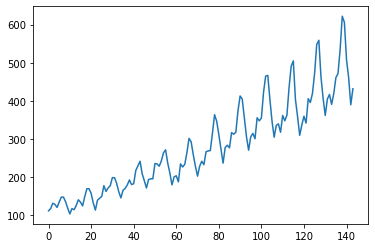

In [10]:
plt.plot(timeseries) #非常有规律的一个数据，对于LSTM来说相对容易
plt.show()

- **数据分割与滑窗**

In [35]:
#按时间顺序对训练集测试集进行分割
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

> - 什么是滑窗？滑窗在机器学习/深度学习世界中的意义是什么？

滑动窗口技术涉及将连续的数据流划分为多个“窗口”，每个窗口包含一段时间序列的子集。在时间序列预测中，滑动窗口用于创建预测模型的训练样本。例如，如果我们想预测未来某个时间点的值，我们可以使用过去几个时间点的数据作为输入特征。在机器学习和深度学习的世界中，我们都常用滑窗的手段，针对不同的算法，滑窗手法带来的效果却截然不同。以下面的数据为例——

|时间|特征1|特征2|
|:-:|:-:|:-:|
|Date0|xxx|xxx|
|Date1|xxx|xxx|
|Date2|xxx|xxx|
|...|xxx|xxx|
|Daten|xxx|xxx|

在机器学习的世界中，滑窗带有“去时序化”的意味，这是因为机器学习算法（如lgbm，随机森林等等）是研究特征与标签之间关系的算法，机器学习算法群并不研究样本与样本之间的关联，而时间序列的内在逻辑是样本与样本之间的关联逻辑，因此在机器学习当中，我们利用滑窗“去时序化”后，将从上至下的时间序列关联滑窗为从左到右的特征与标签之间的关联。具体来看，在机器学习中，滑窗之后的数据往往呈现如下结构：

|时间|...|Date7前1天<br>特征1|Date7前2天<br>特征1|Date7前3天<br>特征1|...|Date7前1天<br>特征2|Date7前2天<br>特征2|Date7前3天<br>特征2|....|标签|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|Date0|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|
|……|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|
|Date7|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|
|Date8|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|
|Date9|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|
|...|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|
|Date10|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|

但在深度学习、尤其是序列数据的世界中，我们的滑窗操作会生成的数据结构是：

> - **表单1**

|时间|特征1|特征2|
|:-:|:-:|:-:|
|**Date0**|xxx|xxx|
|**Date1**|xxx|xxx|
|**Date2**|xxx|xxx|
|...|xxx|xxx|
|**Date7**|xxx|xxx|
|**标签**|xxx|xxx|

> - **表单2**

|时间|特征1|特征2|
|:-:|:-:|:-:|
|**Date1**|xxx|xxx|
|**Date2**|xxx|xxx|
|**Date3**|xxx|xxx|
|...|xxx|xxx|
|**Date8**|xxx|xxx|
|**标签**|xxx|xxx|

> - **表单3**

|时间|特征1|特征2|
|:-:|:-:|:-:|
|**Date2**|xxx|xxx|
|**Date3**|xxx|xxx|
|**Date4**|xxx|xxx|
|...|xxx|xxx|
|**Date9**|xxx|xxx|
|**标签**|xxx|xxx|

这两种滑窗结构有明显的不同，其核心特点是“**时间维度的不同**”和“**能否打乱纵向的样本排列顺序**”，因两种不同的滑窗结构，这两种数据也适用于不同的机器学习和深度学习算法。

在本次单变量时间序列数据案例当中，我们采用的是第二种方法进行滑窗。在滑窗技巧中，有两个关键的因素非常重要，一个是“窗的大小”，另一个是“滑动的步长”。在大多数的时候我们只会考虑窗的大小，而一般不对步长进行修改。

In [45]:
#单变量时间序列滑窗函数

import torch
def create_dataset(dataset, lookback):
    """
    将时间序列转变为能够用于训练和预测的数据
    
    参数:
        dataset: ndarry，第一个维度是时间
        lookback: 滑窗的窗的大小
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+lookback]
        #target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.FloatTensor(X), torch.FloatTensor(y)

> - 滑窗函数代码解析

In [46]:
#创建训练集与测试集
lookback = 7
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([89, 7, 1]) torch.Size([89, 1])
torch.Size([41, 7, 1]) torch.Size([41, 1])


In [47]:
for x_, y_ in zip(X_train,y_train):
    print(x_,y_)
    break

tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.],
        [135.],
        [148.]]) tensor([148.])


In [48]:
y_train[0]

tensor([148.])

- **定义网络架构与训练元素**

In [67]:
#选择了最为简单的网络架构来进行实验
import torch.nn as nn
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        #现在我要的是最后一个时间步，而不是全部时间步了
        x = self.linear(x[:,-1,:])
        return x

In [68]:
#设置GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [69]:
#设置参数
input_size = 1  #输入特征的维度
hidden_size = 50 #LSTM隐藏状态的维度
num_layers = 1 #LSTM层的数量
output_size = 1 #模型的输出维度
n_epochs = 2000 #迭代epoch
learning_rate = 0.001 #学习率

In [70]:
#实例化模型
model = AirModel().to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate) #定义优化器
loss_fn = nn.MSELoss() #定义损失函数
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8) #将数据分批次

In [71]:
for x,y in loader:
    print(x.shape)
    print(y)
    break

torch.Size([8, 7, 1])
tensor([[234.],
        [355.],
        [259.],
        [193.],
        [293.],
        [163.],
        [243.],
        [302.]])


- **实际训练流程**

In [72]:
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #验证与打印
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train.to(device)).cpu()
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test.to(device)).cpu()
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 231.3658, test RMSE 428.8696
Epoch 100: train RMSE 186.5346, test RMSE 382.1577
Epoch 200: train RMSE 152.2639, test RMSE 345.3699
Epoch 300: train RMSE 122.5366, test RMSE 311.7413
Epoch 400: train RMSE 98.6056, test RMSE 281.7494
Epoch 500: train RMSE 71.8821, test RMSE 244.2719
Epoch 600: train RMSE 54.0116, test RMSE 213.5541
Epoch 700: train RMSE 42.0944, test RMSE 194.0356
Epoch 800: train RMSE 34.5988, test RMSE 174.8605
Epoch 900: train RMSE 29.7907, test RMSE 170.5281
Epoch 1000: train RMSE 26.6360, test RMSE 141.6537
Epoch 1100: train RMSE 23.8831, test RMSE 132.5804
Epoch 1200: train RMSE 23.5865, test RMSE 121.6976
Epoch 1300: train RMSE 19.9781, test RMSE 118.3079
Epoch 1400: train RMSE 18.7755, test RMSE 112.8421
Epoch 1500: train RMSE 17.3526, test RMSE 107.7514
Epoch 1600: train RMSE 15.9780, test RMSE 100.3437
Epoch 1700: train RMSE 14.3680, test RMSE 97.0989
Epoch 1800: train RMSE 13.2114, test RMSE 94.9483
Epoch 1900: train RMSE 12.3218, test RMSE

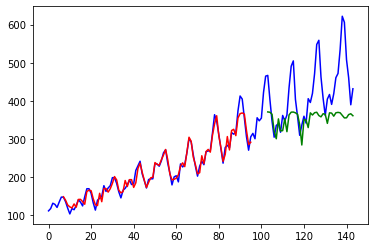

In [78]:
with torch.no_grad():
    # 绘制训练集上的损失的图像
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train.to(device)).cpu()
    train_plot[lookback:train_size] = model(X_train.to(device)).cpu()
    # 绘制测试集上的损失的图像
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test.to(device)).cpu()
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

- **从序列到点的预测转变为序列到序列的预测**

序列到序列（Seq2Seq）预测和序列到点（Seq2Point）预测在处理时间序列数据时各有优势。特别是对于LSTM这样的循环神经网络，这两种方法都可以被有效地利用。让我们来比较一下它们各自的优势：

> 序列到序列（Seq2Seq）预测

捕获长期依赖关系：Seq2Seq模型特别适合于那些需要理解整个输入序列来生成整个输出序列的任务。LSTM的优势在于能够捕获长期的时间依赖性，这使得它在Seq2Seq预测中非常有效。

连续输出预测：当需要连续预测多个未来时间点时，Seq2Seq模型可以一次性提供整个输出序列，这对于需要连续决策或规划的应用非常有用。

灵活性和泛化能力：Seq2Seq模型可以被训练来处理不同长度的输入和输出序列，提供更高的灵活性和泛化能力。

多功能性：Seq2Seq模型不仅限于时间序列预测，还可以用于其他任务，如机器翻译、文本摘要等。

> 序列到点（Seq2Point）预测

简单性和高效性：Seq2Point模型通常比Seq2Seq模型更简单，易于实现和训练。这种方法在计算上更高效，因为它仅预测单个输出值。

准确性：在某些情况下，Seq2Point模型可能比Seq2Seq模型提供更准确的单点预测，因为它专注于预测一个特定的未来时刻，而不是整个序列。

降低过拟合风险：由于模型结构较为简单，Seq2Point模型可能较少受到过拟合的影响，尤其是在数据量较少的情况下。

适用性：Seq2Point预测非常适用于那些只需预测一个未来时刻的任务，例如短期负载预测或股价预测。

选择Seq2Seq还是Seq2Point模型取决于具体的应用需求。如果任务涉及到对未来一系列时间点的连续预测，Seq2Seq模型是更好的选择。然而，如果任务只需要预测一个特定的未来时刻，Seq2Point模型可能更为合适，因为它更简单、更高效，并且可能更准确。在实际应用中，考虑数据的特性、预测的需求和可用资源是非常重要的。

In [79]:
import torch
def create_dataset(dataset, lookback):
    """
    序列到序列预测的滑窗函数
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.FloatTensor(X), torch.FloatTensor(y)

In [80]:
lookback = 7
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([89, 7, 1]) torch.Size([89, 7, 1])
torch.Size([41, 7, 1]) torch.Size([41, 7, 1])


In [85]:
for x_, y_ in zip(X_train,y_train):
    print(x_, "\n \n", y_)
    break

tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.],
        [135.],
        [148.]]) 
 
 tensor([[118.],
        [132.],
        [129.],
        [121.],
        [135.],
        [148.],
        [148.]])


In [86]:
import torch.nn as nn
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [87]:
#device = "cpu"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [88]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
 
model = AirModel().to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train.to(device)).cpu()
        train_rmse = np.sqrt(loss_fn(y_pred
                                     , y_train))
        y_pred = model(X_test.to(device)).cpu()
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 224.8474, test RMSE 423.6746
Epoch 100: train RMSE 175.4201, test RMSE 371.9661
Epoch 200: train RMSE 137.3603, test RMSE 330.4726
Epoch 300: train RMSE 106.9641, test RMSE 294.4650
Epoch 400: train RMSE 84.8498, test RMSE 263.3934
Epoch 500: train RMSE 63.0843, test RMSE 230.6918
Epoch 600: train RMSE 49.2545, test RMSE 203.6607
Epoch 700: train RMSE 39.5057, test RMSE 180.2176
Epoch 800: train RMSE 33.1067, test RMSE 160.2575
Epoch 900: train RMSE 28.1978, test RMSE 143.7549
Epoch 1000: train RMSE 24.8665, test RMSE 129.6951
Epoch 1100: train RMSE 22.2744, test RMSE 116.9509
Epoch 1200: train RMSE 20.2718, test RMSE 107.0073
Epoch 1300: train RMSE 19.2075, test RMSE 99.3532
Epoch 1400: train RMSE 20.5165, test RMSE 93.5716
Epoch 1500: train RMSE 18.2590, test RMSE 90.8696
Epoch 1600: train RMSE 17.6633, test RMSE 87.0046
Epoch 1700: train RMSE 17.3083, test RMSE 83.9677
Epoch 1800: train RMSE 16.9683, test RMSE 82.5182
Epoch 1900: train RMSE 16.9705, test RMSE 81.

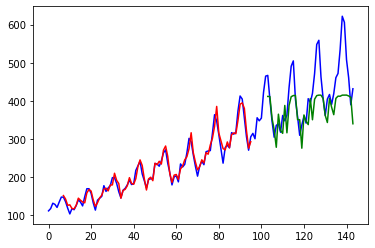

In [89]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train.to(device)).cpu()
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train.to(device)).cpu()[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test.to(device)).cpu()[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

### 1.5.2 股价预测数据集的一般解决方法

In [567]:
# 读取CSV文件
df_stock_prices = pd.read_csv('stock_prices.csv')

In [568]:
df_stock_prices.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


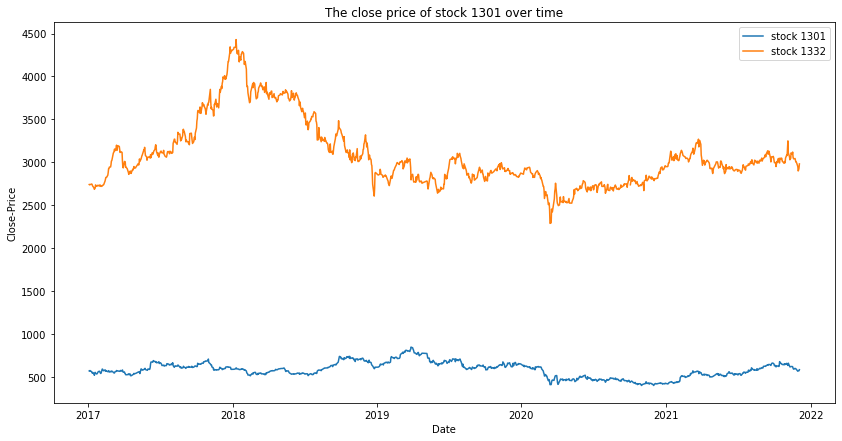

In [569]:
# 选择单只股票的数据
single_stock = df_stock_prices[df_stock_prices['SecuritiesCode'] == 1332]
stock_1332 = df_stock_prices[df_stock_prices['SecuritiesCode'] == 1301]

# 绘制单只股票的'High'价格的时间序列图
plt.figure(figsize=(14, 7))
# 横坐标为日期，纵坐标为收盘价close
# 因为当前数据集的'Date'字段是object类型，所以我们需要转化为datetime类型
plt.plot(pd.to_datetime(single_stock['Date']), single_stock['Close'],label='stock 1301')#1332
plt.plot(pd.to_datetime(stock_1332['Date']), stock_1332['Close'],label='stock 1332')
plt.xlabel('Date')
plt.ylabel('Close-Price')
plt.title('The close price of stock 1301 over time')
plt.legend()
plt.show()

**我们先选取1301单只股票的'High'价格，做单变量的时序预测实验，来看一下用LSTM做时序预测的基本代码流程框架。**


- **数据筛选和清洗**

* 构建新的实验数据集：选取1301单只股票的'High'价格，构建单变量的时序数据集。
* 数据清洗筛选 \
通常在数据预处理阶段，我们会进行缺失值、异常值、重复值的处理，数据类型的调整转换，不同特征数值的归一化等工作。本次实验的数据集较为简单，只有单个特征，在这里只进行简单的数据预处理，完备的数据预处理我们在后续多特征变量时序预测部分展开。

In [570]:
single_stock.set_index('Date', inplace=True)  #将日期列的时序数据设为index
single_stock = single_stock[['High']]  #选取high即单日最高价作为实验数据

In [571]:
missing_indices = single_stock[single_stock['High'].isnull()].index
missing_indices

Index(['2020-10-01'], dtype='object', name='Date')

我们打开数据集查看一下2020年10月1日，1301股票的数据情况。如下图：
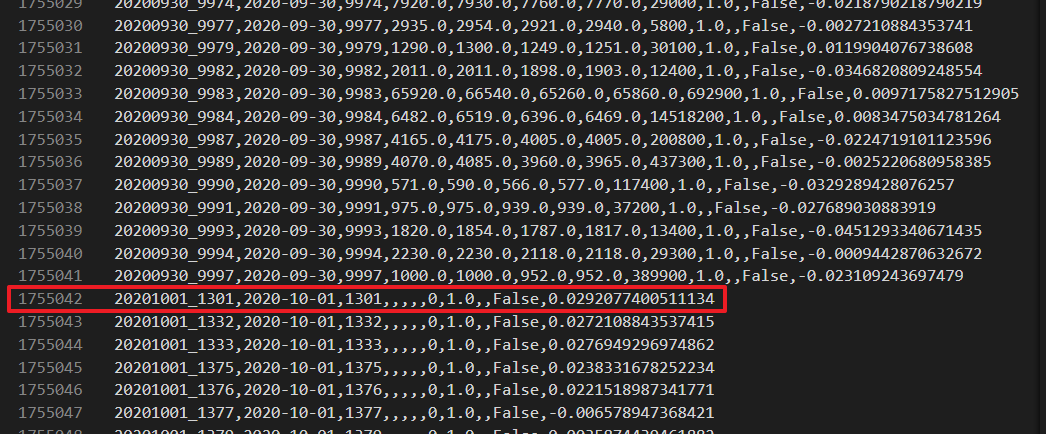 \
可以发现2020年10月1日当日 ，所有股票的信息都出现了缺失，可能是因为一些故障原因当日没有记录。（也可能是竞赛官方故意抹去这一天的数据构造有缺失情况的数据集） 

总之，数据集有1202个样本，删除这个取值为NAN的异常值样本1个，得到数据集1201个样本。

In [572]:
single_stock.dropna(inplace=True)  # 删除包含NaN值的行
single_stock.shape

(1201, 1)

In [573]:
duplicate_index = single_stock.index[single_stock.index.duplicated()]
duplicate_index

Index([], dtype='object', name='Date')

返回的是空列表，数据中没有重复值。

In [574]:
single_stock.head()

,High
Date,
2017-01-04,576.0
2017-01-05,573.0
2017-01-06,576.0
2017-01-10,576.0
2017-01-11,562.0


In [575]:
single_stock.shape

(1201, 1)

In [576]:
df = pd.read_csv('airline-passengers.csv')

In [577]:
df.set_index('Month', inplace=True)

- **在股价数据集上进行预测**

In [92]:
df_stock_prices = pd.read_csv('stock_prices.csv')
timeseries = df_stock_prices.loc[df_stock_prices['SecuritiesCode'] == 1332,"Close"]

In [78]:
imeseries.dropna(inplace=True)

In [79]:
timeseries = np.array(timeseries).reshape(-1,1)

In [81]:
#按时间顺序对训练集测试集进行分割
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [83]:
#滑窗函数

import torch
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.FloatTensor(X), torch.FloatTensor(y)

In [84]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([803, 1, 1]) torch.Size([803, 1, 1])
torch.Size([396, 1, 1]) torch.Size([396, 1, 1])


In [85]:
import torch.nn as nn
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [86]:
#device = "cpu"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [87]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
 
model = AirModel().to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train.to(device)).cpu()
        train_rmse = np.sqrt(loss_fn(y_pred
                                     , y_train))
        y_pred = model(X_test.to(device)).cpu()
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 621.2180, test RMSE 515.3440
Epoch 100: train RMSE 481.2728, test RMSE 375.9167
Epoch 200: train RMSE 340.4786, test RMSE 236.7502
Epoch 300: train RMSE 205.8483, test RMSE 110.8597
Epoch 400: train RMSE 96.1053, test RMSE 82.6110
Epoch 500: train RMSE 73.2581, test RMSE 126.5352
Epoch 600: train RMSE 73.2538, test RMSE 127.1442
Epoch 700: train RMSE 73.2538, test RMSE 127.2189
Epoch 800: train RMSE 73.2538, test RMSE 127.2437
Epoch 900: train RMSE 73.2538, test RMSE 127.2160
Epoch 1000: train RMSE 73.2538, test RMSE 127.2654
Epoch 1100: train RMSE 73.2538, test RMSE 127.1521
Epoch 1200: train RMSE 73.2538, test RMSE 127.1724
Epoch 1300: train RMSE 73.2538, test RMSE 127.2470
Epoch 1400: train RMSE 73.2538, test RMSE 127.1790
Epoch 1500: train RMSE 73.2539, test RMSE 127.2747
Epoch 1600: train RMSE 73.2538, test RMSE 127.1745
Epoch 1700: train RMSE 73.2538, test RMSE 127.1602
Epoch 1800: train RMSE 73.2538, test RMSE 127.2321
Epoch 1900: train RMSE 73.2538, test RMS

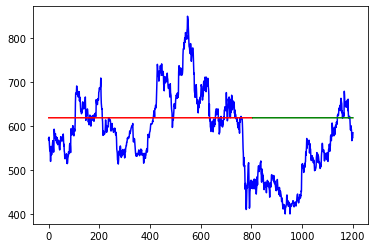

In [88]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train.to(device)).cpu()
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train.to(device)).cpu()[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test.to(device)).cpu()[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

- 用于股价预测数据集的特征工程手段

In [94]:
# typing 模块提供了一些类型，用于类型提示
from typing import Union,List,Tuple,Iterable

In [95]:
def create_feature(df_temp:pd.DataFrame,periods:Union[List,Tuple,Iterable])->pd.DataFrame:
    """
    :param df_temp: pd.DataFrame, 输入的数据框，其中需要包含金融时间序列数据。
                    数据框需要至少包含日期、股票代码、收盘价、调整收盘价、最高价、最低价等列。
                    其中日期会被用于排序，股票代码用于分组操作，而其他列用于特征工程。

    :param periods: Union[List, Tuple, Iterable], 一个可迭代的对象（如列表、元组等），包含了想要用于计算历史数据平移和窗口统计的时间段。
                    例如，如果想要考虑过去5天、10天和20天的数据，那么periods就应该是[5, 10, 20]。

    :return: pd.DataFrame, 增加了新特征的数据框。
    """
    df = df_temp.copy()
    df.sort_values(by='Date',inplace=True)
    key_col = 'SecuritiesCode'

    # 历史平移
    for period in periods:
        df.loc[:,f'history_close_{period}']=df.groupby(key_col)['Close'].shift(period)

        #窗口统计
        for stat in ['mean', 'std', 'max', 'min', 'median']:
            df.loc[:,f'window_close_{period}_{stat}'] = df.groupby(key_col)['AdjustedClose'].rolling(window=period).agg(stat).values

        # max-min feature
        df.loc[:,f'window_close_{period}_max-min'] = df[f'window_close_{period}_max']-df[f'window_close_{period}_min'].values
        # 波动率
        avg_value = (df[f'window_close_{period}_max'] + df[f'window_close_{period}_min']) / 2
        df.loc[:,f'window_close_{period}_fluctuation_rate'] = df[f'window_close_{period}_max-min'] / avg_value
        
        #增长率特征
        df.loc[:,f'window_close{period}_pctchange'] = df.groupby(key_col)['AdjustedClose'].pct_change(period).values

        # diff 特征
        df.loc[:,f'window_close{period}_diff'] = df.groupby(key_col)['AdjustedClose'].diff(period).values
        df.loc[:,f"Volatility_{period}Day"] = np.log(df['AdjustedClose']).groupby(df[key_col]).diff().rolling(period).std()

        # 扩张窗口特征
        df.loc[:,f"ExpMovingAvg_{period}Day"] = df.groupby(key_col)['AdjustedClose'].ewm(span=period,adjust=False).mean().values  
    
    # 尝试使用times参数，衰减因子只能选择halflife，这里我们设置为5D(天)【5天为一周】
    # 发现效果并不好
#     times = pd.to_datetime(df['Date'])
#     df.loc[:,"ExpMovingAvg_{}Day".format(period)] = df.groupby(key_col)['AdjustedClose'].ewm(times=times,halflife='5D').mean().values

    df.loc[:,f'expand_mean'] = df.groupby(key_col)['Close'].expanding().mean().values
    
    df['Upper_Shadow'] = df['High'] - df[['Close', 'Open']].max(axis=1)
    df['Lower_Shadow'] = df[['Close', 'Open']].min(axis=1) - df['Low']

    
    # 基础时间特征
    time_feature = timeseries_feature(df['Date'])
    return pd.concat((df,time_feature),axis=1)